# EDA Question 3

For this portion of the project, we will attempt to answer the third question proposed in our original Business Goals:

**Business Goal 3:** Explore how the subreddit page of the NCAA champion in 2022, the Kansas Jayhawks, varied over the course of the season. Identify any trends in post frequency or comment length that may correlate to on-the-court successes or failures. 

**Technical Proposal:** Use trend analysis and count number of comments and comment lengths to determine excitement over the course of the CBB season. Correlate any major trends to outside data sets, including Jayhawks wins and losses or major games. Analyze any additional trends in activity over the course of the 2022 season to find any other additional results before entering into the NLP phase of the project.

As you will see throughout this exploration, this analysis began as only covering the r/jayhawks subreddit, but we expanded it to also include the r/tarheels subreddit as well. This initial glimpse into how these subreddits work will lead into other analyses as we continue. Thus, we effectively added the following business goal:

**Business Goal 3.5:** Explore how the subreddit page of the NCAA runner ups in 2022, the UNC Tarheels, varied over the course of the season. Identify any trends in post frequency or comment length that may correlate to on-the-court successes or failures. 

**Technical Proposal:** Use trend analysis and count number of comments and comment lengths to determine excitement over the course of the CBB season. Correlate any major trends to outside data sets, including UNC wins and losses or major games. Analyze any additional trends in activity over the course of the 2022 season to find any other additional results before entering into the NLP phase of the project.

### Configuring and Cleaning the Data

This process will be the same across our EDA questions.

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 6, Finished, Available)

In [2]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 7, Finished, Available)

In [26]:
#datastore = 'azureml://datastores/workspaceblobstore/paths'
comments_path = "/basketball_comments_sep.parquet"
submissions_path = "/basketball_submissions_sep.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 31, Finished, Available)

In [4]:
submissions = submissions.cache()
comments = comments.cache()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 9, Finished, Available)

In [5]:
submissions = submissions.filter((submissions.selftext != "") & (submissions.selftext != "[deleted]")& (submissions.selftext != "[removed]"))
comments = comments.filter(comments.body != "")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 10, Finished, Available)

## Showing Frequency of Comments and Submissions in r/jayhawks

In order to analyze these subreddits, we'll begin by diving into the comment and submission frequency for r/jayhawks.

In [6]:
from pyspark.sql.functions import *
jayhawk_comments = (
    comments
    .filter(col("subreddit") == "jayhawks")
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
    .groupBy("year", "month", "day")
    .count()
)
jayhawk_comments_df = jayhawk_comments.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 11, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 12, Finished, Available)

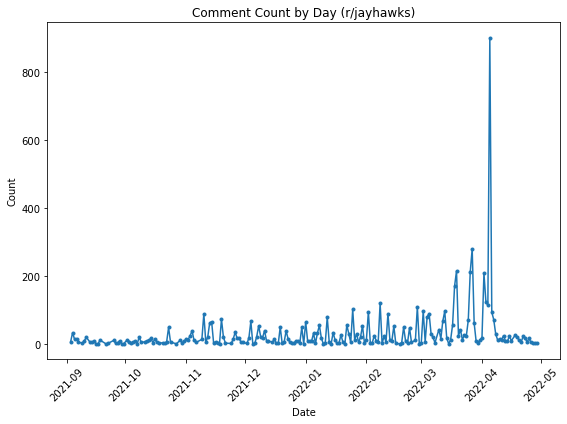

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

jayhawk_comments_df['date'] = pd.to_datetime(jayhawk_comments_df[['year', 'month', 'day']])
jayhawk_comments_df = jayhawk_comments_df.sort_values(by='date') 
plt.figure(figsize=(8, 6))
plt.plot(jayhawk_comments_df['date'], jayhawk_comments_df['count'], marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Comment Count by Day (r/jayhawks)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This shows us the comment frequency for r/jayhawks. 

This showed us some interesting things right off the bat about this subreddit. First, the primary thing that sticks out about this graph is that by far and away, the most comments occur in late March and early April. This aligns perfectly with earlier hypotheses that the most interaction on this subreddit would be during the NCAA March Madness tournament. 

Taking this a step further, the Jayhawks won the NCAA Championship on 4 April 2022. This aligns perfect with the huge spike - which is likely that championship game. According to Forbes (https://www.forbes.com/sites/masonbissada/2022/04/05/kansas-unc-game-is-most-watched-ncaa-basketball-final-in-cable-tv-history/?sh=773024af1a0e), this was the most-watched NCAA final game in history, so this spike correlates nicely with that!

There is a general "buzz" about the Jayhawks primarily during the collegiate basketball season - November through April. Our data only includes the CBB season, but we can extrapolate from the near-zero comment rate in September that there is not much excitement around the team other than during the season - to include big recruiting commitments.

Before the season, fans (https://www.cjonline.com/story/sports/college/hawk-zone/2021/11/23/kansas-basketball-schedule-2021-2022-jayhawks-big-12-most-important-games-mizzou-border-war/8608871002/) identified a number of games that were must watches: December 11, December 21, January 1, January 22, January 29, among others. Although there were potentially smaller spikes in comments during these games, there were vastly outweighed by the increased rate of comments during the finals and the NCAA tournament. 

This will help inform our analysis in the future: because the number of comments on this page was so much smaller than on the main r/CollegeBasketball page, our analysis may be more prescient taking Kansas mentions on that main page and using that information instead of focusing on this subreddit.


Let's do the same thing for submissions and see if we get a similar result.

In [8]:
jayhawk_submissions = (
    submissions
    .filter(col("subreddit") == "jayhawks")
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
    .groupBy("year", "month", "day")
    .count()
)
jayhawk_submissions_df = jayhawk_submissions.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 13, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 14, Finished, Available)

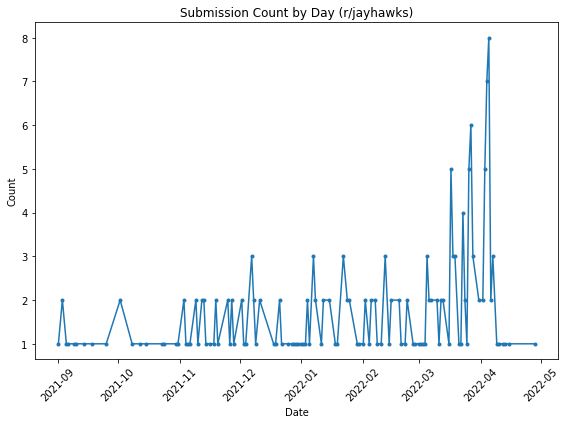

In [9]:
jayhawk_submissions_df['date'] = pd.to_datetime(jayhawk_submissions_df[['year', 'month', 'day']])
jayhawk_submissions_df = jayhawk_submissions_df.sort_values(by='date') 
plt.figure(figsize=(8, 6))
plt.plot(jayhawk_submissions_df['date'], jayhawk_submissions_df['count'], marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Submission Count by Day (r/jayhawks)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Okay! Now we've completed the initial stages of our exploratory data analysis for r/jayhawks.

There were so few submissions on the page that the maximum number of submissions in one day was eight! This tells us a lot about how Jayhawk fans react - they don't do it on this page! Maybe there is more interest on the larger page - maybe there is increased engagement there, and that is preferable for Jayhawk fans. We'll be able to find that out in the next EDA question.

We are going to continue this analysis and also do the same thing for r/tarheels.

## Showing Frequency of Comments and Submissions in r/tarheels

In order to analyze these subreddits, we'll begin by diving into the comment and submission frequency for r/tarheels.

In [10]:
tarheel_comments = (
    comments
    .filter(col("subreddit") == "jayhawks")
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
    .groupBy("year", "month", "day")
    .count()
)
tarheel_comments_df = tarheel_comments.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 15, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 16, Finished, Available)

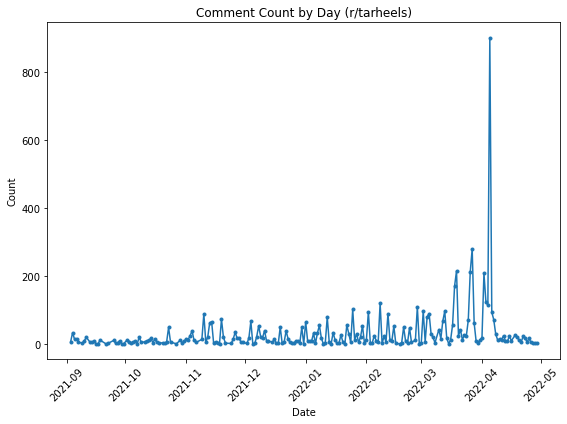

In [11]:
tarheel_comments_df['date'] = pd.to_datetime(tarheel_comments_df[['year', 'month', 'day']])
tarheel_comments_df = tarheel_comments_df.sort_values(by='date') 
plt.figure(figsize=(8, 6))
plt.plot(tarheel_comments_df['date'], tarheel_comments_df['count'], marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Comment Count by Day (r/tarheels)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

That's a good start! This is interesting to compare to the r/jayhawks analysis of before.

The commenting patterns and spike follow the same pattern as the r/jayhawks subreddit. There is minimal engagement before the tournament, with some excitement building in February and March. Then, during the main tournament and especially during the 4 April championship game, there is a huge spike in comments!

A number of games were identified by fans (https://watchstadium.com/college-basketball-must-see-games-in-2021-22-10-27-2021/) as must-watch throughout the season. The following is an excerpt from the linked article about the games the fandom was most excited for:

1. North Carolina at Duke, March 5 – It’ll be the swan song at Cameron for Mike Krzyzewski, and it comes, of course, against rival North Carolina. The atmosphere in this one will be insane. Coach K announced he will retire after this season, and his final home game is against the Tar Heels in the ACC regular-season finale. I can’t wait to see what the resale market looks like for this matchup.

2. Duke vs. Kentucky, Nov. 9 in New York – This is Coach K vs. John Calipari for one final time in the Champions Classic, basically opening the college hoops season. Both come off disappointing campaigns, and both will have a chance to get some early momentum this year. It’ll also feature two of the top frosh in the country: Duke’s Paolo Banchero and Kentucky’s TyTy Washington.

3. Gonzaga vs. Duke, Nov. 26 in Las Vegas – Two of the best programs, and arguably the two best freshmen, go up against one another at T-Mobile Arena. The Zags have long and skilled 7-footer Chet Holmgren, while Duke will rely heavily on big, strong and athletic forward Paolo Banchero.

4. Gonzaga vs. UCLA, Nov. 23 in Las Vegas – A rematch of the Final Four matchup in which Jalen Suggs hit the memorable game-winning shot, and both are contenders to cut down the nets this year.

5. Texas at Gonzaga, Nov. 13 – New Longhorns coach Chris Beard takes his team to Spokane and will face Drew Timme, Chet Holmgren and the top-ranked Zags. It’s a chance for Texas and all of Beard’s transfers to show they are for real.

6. Villanova at UCLA, Nov. 12 – A matchup of two top-five teams out at Pauley Pavilion. Villanova brought back a pair of fifth-year guys in Collin Gillespie and Jermaine Samuels, while UCLA will be led by March Madness star Johnny Juzang.

7. Texas at Texas Tech, Feb. 1 – This is one you need to be in Lubbock for to truly appreciate the atmosphere. It won’t exactly be a heartwarming homecoming for Chris Beard. Sure, he led the Red Raiders to a national title game appearance and an Elite Eight, but the fans in Lubbock still can’t come to grips with why he’d leave for UT. In fact, they strongly dislike Beard now. This is his first appearance back in Lubbock, and it’ll be interesting to see the reception he receives from the fan base. I don’t expect a lot of pleasantries.

8. Kentucky at Kansas, Jan. 29 – It’s Kentucky vs. Kansas in the Big 12/SEC Challenge at Allen Fieldhouse. Need I say more?

As per the r/jayhawks subreddit, although there may have been a spike on these dates, nothing compares whatsoever to the spike around the championship engagement.

Just as before, we'll do the same thing for submissions.

In [12]:
tarheel_submissions = (
    submissions
    .filter(col("subreddit") == "tarheels")
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
    .groupBy("year", "month", "day")
    .count()
)
tarheel_submissions_df = tarheel_submissions.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 17, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 18, Finished, Available)

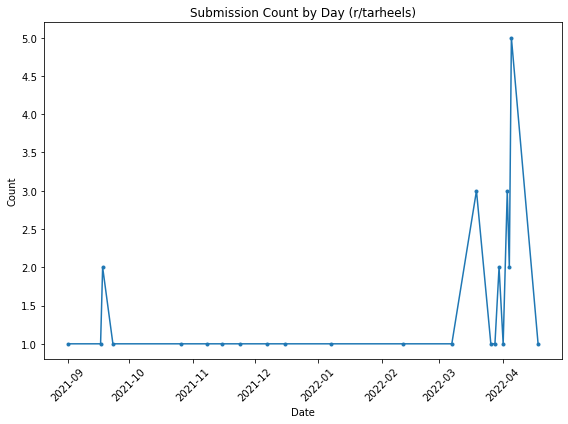

In [13]:
tarheel_submissions_df['date'] = pd.to_datetime(tarheel_submissions_df[['year', 'month', 'day']])
tarheel_submissions_df = tarheel_submissions_df.sort_values(by='date') 
plt.figure(figsize=(8, 6))
plt.plot(tarheel_submissions_df['date'], tarheel_submissions_df['count'], marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Submission Count by Day (r/tarheels)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Wow! There were many fewer submissions on the tarheels subreddit than the jayhawks subreddit. This could, again, be due to a number of reasons, and maybe the engagement on the main page makes up for this difference. We'll have to see in our next portion of EDA!

## Continued Analysis: Do these teams appear on r/CollegeBasketball?

We found that many of the questions that arose during our question 3 analysis aligned nicely with the next step of our process: finding which team mentions in the main subreddit occurred the most often. Please see our EDA Question 5 for more information.

## Length of Comments throughout r/Jayhawks

Now, we'll dive in a little more into the subreddit and try to extract interesting insights from the length of comment and submission in r/jayhawks.

In [20]:
from pyspark.sql.functions import col

submissions_l = submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").filter(col("subreddit") == "jayhawks")

comments_l = comments.select("subreddit", "author", "body", "parent_id", "created_utc").filter(col("subreddit") == "jayhawks")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 25, Finished, Available)

In [22]:
from pyspark.sql.functions import col, length

submissions_l = submissions_l.withColumn("selftext_word_count", length(col("selftext")))
comments_l = comments_l.withColumn("body_word_count", length(col("body")))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 27, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 30, Finished, Available)

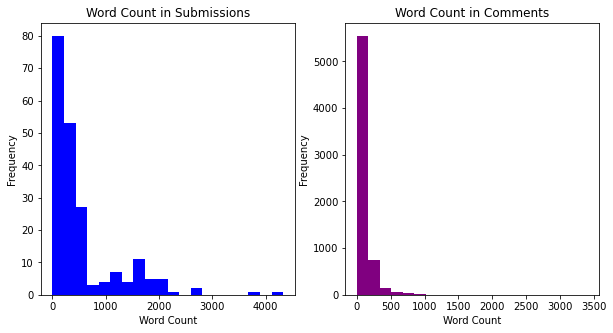

In [25]:
selftext_word_count = submissions_l.select("selftext_word_count").rdd.flatMap(lambda x: x).collect()
body_word_count = comments_l.select("body_word_count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(selftext_word_count, bins=20, color='blue')
plt.title('Word Count in Submissions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(body_word_count, bins=20, color='purple')
plt.title('Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

Wow! This really helped contextualize the number of comments and submissions on this subreddit. For the submissions, a majority of the submissions were less than 500 words, although there was a small spike of 1500-word submissions. This is interesting, and to me shows that some submissions were written by people who care a lot and take the time to write out lengthy responses. On the other hand, a large majority of all comments were less than 100 words. 

Let's do the same thing for the r/tarheels page and see what we see there.

In [27]:
submissions_w = submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").filter(col("subreddit") == "tarheels")
comments_w = comments.select("subreddit", "author", "body", "parent_id", "created_utc").filter(col("subreddit") == "tarheels")


submissions_w = submissions_w.withColumn("selftext_word_count", length(col("selftext")))
comments_w = comments_w.withColumn("body_word_count", length(col("body")))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 32, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 25, 33, Finished, Available)

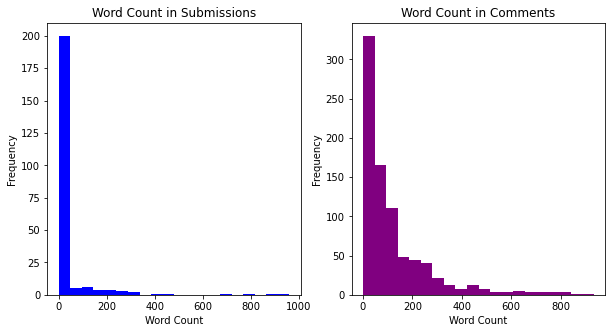

In [28]:
selftext_word_count = submissions_w.select("selftext_word_count").rdd.flatMap(lambda x: x).collect()
body_word_count = comments_w.select("body_word_count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(selftext_word_count, bins=20, color='blue')
plt.title('Word Count in Submissions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(body_word_count, bins=20, color='purple')
plt.title('Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

Very weird! This looks very different than the r/jayhawks version. The number of words in the comments and submissions is lower, and there is no relative increase in mid-length postings like there was in the previous iteration. We'd be interested in if any of these trends continue for the main page.

This concludes our analysis of Exploratory Data Analysis Question 3. Thank you!